In [2]:
import sys
sys.path.append("../src")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import umap
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from lib.i_o import read_csv

## Read data

In [3]:
df_x_train = read_csv("X_train.csv", "../data/").drop(columns="id")
df_y_train = read_csv("y_train.csv", "../data/").drop(columns="id")

Read data from ../data/X_train.csv
Read data from ../data/y_train.csv


In [4]:
df_x_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,14168.823171,10514.380717,3316.149698,94230.695124,102.386606,92.677127,11108.748199,10866.505510,10837.622093,10.227734,...,NaN,12352.094085,846.014651,105.132144,102.112809,2090.004260,2.691845,1234.374109,1000.784475,9285.751272
1,17757.037554,NaN,4101.016273,92959.527633,NaN,99.855168,10013.959449,10826.607494,10076.101597,11.436970,...,NaN,16198.071494,776.084467,106.385590,103.472030,2474.051881,2.287976,NaN,1012.626705,11750.284764
2,14226.656663,11029.642499,NaN,124055.600561,100.542483,92.860892,NaN,10492.342868,NaN,10.810076,...,10329.704431,13976.063780,737.040332,103.671234,109.458246,2656.083281,2.843706,888.353607,1048.810385,9553.922728
3,8766.012436,7384.202998,2147.308418,100157.719990,104.855061,101.929026,10050.049932,10499.521099,10525.030989,10.092109,...,10008.251395,6212.127347,329.044233,105.084488,104.858546,1097.785204,2.732257,927.752967,1048.357330,NaN
4,13801.016418,13269.493652,3408.316953,92048.527786,103.759758,95.789235,9667.353978,10750.783106,10618.800750,12.006773,...,10095.782015,13772.061493,NaN,NaN,100.369834,2693.053231,2.702908,1471.354073,1071.284484,9423.533063


In [5]:
# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_x_train, df_y_train, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1) 

In [6]:
print(f"#Features: {df_x_train.shape[1]}\n#observations: {df_x_train.shape[0]}")

#Features: 832
#observations: 1212


## Model training

In [9]:
# subsample 0.7, n_estimators: 75, max_features 0.9

In [20]:
# Rewrite preprocessing and model as a sklearn pipeline
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler())
, ('imputer', KNNImputer())
, ('feature_selector', SelectFromModel(selector_model))
, ('regression_model', GradientBoostingRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__weights="distance",
    feature_selector__threshold="2*mean",
)

# Set grid / solution space
n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  [35]
n_subsample_range = [0.91]
learning_rate_range = [0.19]

parameters = {
     'regression_model__n_estimators':n_estim_range
    , 'regression_model__subsample': n_subsample_range
    , 'feature_selector__threshold': feature_sel_threshold_range
    , 'regression_model__max_features': n_max_features_range
    , 'regression_model__learning_rate': learning_rate_range
}

n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  [35]
n_subsample_range = [0.91]
learning_rate_range = [0.19]

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=-1, cv=5, return_train_score=True)
grided_model.fit(X_train, np.array(y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

Elapsed time 4.734 min


In [11]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [12]:
grided_model.cv_results_["params"]

[{'feature_selector__threshold': '1.5*mean',
  'regression_model__learning_rate': 0.19,
  'regression_model__max_features': 0.9,
  'regression_model__n_estimators': 35,
  'regression_model__subsample': 0.91},
 {'feature_selector__threshold': '1.55*mean',
  'regression_model__learning_rate': 0.19,
  'regression_model__max_features': 0.9,
  'regression_model__n_estimators': 35,
  'regression_model__subsample': 0.91},
 {'feature_selector__threshold': '1.6*mean',
  'regression_model__learning_rate': 0.19,
  'regression_model__max_features': 0.9,
  'regression_model__n_estimators': 35,
  'regression_model__subsample': 0.91},
 {'feature_selector__threshold': '1.65*mean',
  'regression_model__learning_rate': 0.19,
  'regression_model__max_features': 0.9,
  'regression_model__n_estimators': 35,
  'regression_model__subsample': 0.91},
 {'feature_selector__threshold': '1.7*mean',
  'regression_model__learning_rate': 0.19,
  'regression_model__max_features': 0.9,
  'regression_model__n_estimators

In [18]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score'
    #, 'feature_selector__threshold'
    #, 'regression_model__n_estimators'
    #, 'feature_selector__threshold'
    #, 'regression_model__max_features'
    #, 'regression_model__subsample'
    #, 'regression_model__learning_rate'
]]

,mean_test_score,mean_train_score,std_test_score,std_train_score,feature_selector__threshold
4,0.474006,0.860219,0.060322,0.008953,1.7*mean
0,0.462036,0.861576,0.021459,0.006678,1.5*mean
14,0.461002,0.852549,0.054125,0.008744,2.2*mean
8,0.460470,0.858130,0.046434,0.010746,1.9*mean
11,0.460261,0.856800,0.085520,0.007733,2.05*mean
1,0.459188,0.857504,0.053812,0.005713,1.55*mean
18,0.459104,0.850728,0.054143,0.006382,2.4*mean
9,0.458353,0.855531,0.055152,0.003197,1.95*mean
7,0.458350,0.859747,0.058287,0.004112,1.85*mean
15,0.457918,0.850905,0.028992,0.009736,2.25*mean


In [14]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    #'regression_model__max_features', 
    'regression_model__n_estimators',
    #'regression_model__subsample',
    #'regression_model__learning_rate'
]].loc[3]

mean_test_score                    0.445139
mean_train_score                   0.858870
std_test_score                     0.044173
std_train_score                    0.003232
regression_model__n_estimators    35.000000
Name: 3, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, '1.7*mean'),
  Text(1, 0, '1.5*mean'),
  Text(2, 0, '2.2*mean'),
  Text(3, 0, '1.9*mean'),
  Text(4, 0, '2.05*mean'),
  Text(5, 0, '1.55*mean'),
  Text(6, 0, '2.4*mean'),
  Text(7, 0, '1.95*mean'),
  Text(8, 0, '1.85*mean'),
  Text(9, 0, '2.25*mean'),
  Text(10, 0, '2.1*mean'),
  Text(11, 0, '2.0*mean'),
  Text(12, 0, '2.3*mean'),
  Text(13, 0, '1.65*mean'),
  Text(14, 0, '1.8*mean'),
  Text(15, 0, '2.35*mean'),
  Text(16, 0, '1.6*mean'),
  Text(17, 0, '2.15*mean'),
  Text(18, 0, '2.45*mean'),
  Text(19, 0, '1.75*mean')])

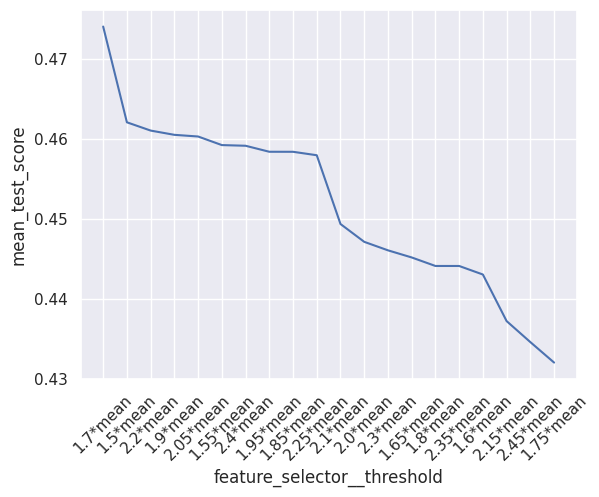

In [19]:
sns.lineplot(data=df_cv_results, x='feature_selector__threshold', y='mean_test_score')

<Axes: xlabel='feature_selector__threshold', ylabel='mean_train_score'>

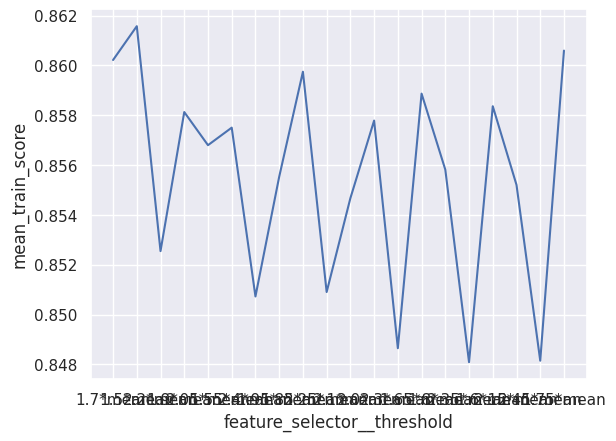

In [17]:
sns.lineplot(data=df_cv_results, x='feature_selector__threshold', y='mean_train_score')

In [ ]:
train_pred = grided_model.predict(X_train)
val_pred = grided_model.predict(X_val)

In [ ]:
validation_score = round(r2_score(y_val, val_pred), 3)
train_score = round(r2_score(y_train_inliers, train_pred), 3)
print(f"Training score {train_score}")
print(f"Validation score {validation_score}")

## Model testing

In [ ]:
from sklearn.pipeline import Pipeline           
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from time import time, sleep

start_t = time()

selector_model = GradientBoostingRegressor(
    random_state=0,
    n_estimators=70,
    subsample=0.7,
    max_features=0.9,
    learning_rate=0.06
)

pipe = Pipeline([
('scaler', preprocessing.RobustScaler()),
('imputer', KNNImputer()),
('feature_selector', SelectFromModel(selector_model)),
('regression_model', GradientBoostingRegressor())
])

pipe.set_params(
    imputer__missing_values=np.nan, 
    imputer__weights="distance",
    feature_selector__threshold="2*mean",
)

# Set grid / solution space
n_max_features_range = [0.9] #np.arange(0.7, 0.98, 0.025)
n_estim_range =  [35]
n_subsample_range = [0.91]
learning_rate_range = [0.19]


parameters = {
    'regression_model__subsample': n_subsample_range
    , 'regression_model__n_estimators':n_estim_range
    , 'regression_model__max_features': n_max_features_range
    , 'regression_model__learning_rate': learning_rate_range
}

# Train grided model
grided_model = GridSearchCV(pipe, parameters, scoring='r2', n_jobs=-1, cv=25, return_train_score=True)
grided_model.fit(df_x_train, np.array(df_y_train).ravel())

print(f"Elapsed time {round((time()-start_t)/60, 3)} min")

In [ ]:
# Collect evaluation data into a data frame
df_cv_results = pd.DataFrame(grided_model.cv_results_)
df_model_params = df_cv_results.apply(lambda x: pd.Series(x["params"]), axis=1)
df_cv_results[df_model_params.columns] = df_model_params
df_cv_results.sort_values(by="rank_test_score", inplace=True)

In [ ]:
df_cv_results.columns

In [ ]:
grided_model.cv_results_["params"]

In [ ]:
df_cv_results[[
    'mean_test_score', 
    'mean_train_score', 
    'std_test_score',
    'std_train_score',
    'mean_fit_time', 
    'std_fit_time'
]]

## Make predictions

In [ ]:
df_sample = read_csv("sample.csv", "../data/")

In [ ]:
df_sample.head()

In [ ]:
df_x_test = read_csv("X_test.csv", "../data/").drop(columns="id")

In [ ]:
df_sample['y'] = grided_model.predict(df_x_test)

In [ ]:
df_sample.to_csv("../data/df_predictions.csv", index=False)